In [2]:
# Import packages
import numpy as np
import pandas as pd
import pickle
import sparseRRR

# Loading Scala 2020 data

First part for the Scala dataset consists of selecting ephys properties, selecting most variable genes and certain cells only.

In [2]:
# Loading raw gene counts
rpkm = pd.read_csv('data/scala_2020/final_patch_seq_allcells_exon_allreads.txt', sep='\t')
rpkm = rpkm.set_index('gene')
new_keys = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) \
            for g in rpkm.keys().tolist()] # Changing column names
rpkm.columns = new_keys
print('all cells with transcriptimic data: ', rpkm.shape)

# Loading raw ephys feature values
M1_ephys = pd.read_csv('data/scala_2020/Cell_Features_M1.csv')
M1_ephys = M1_ephys.drop(['Unnamed: 0'], axis=1)
ephysProperties = ['AP amp FF', 'AP amp', 'AP amp adapt', 'AP amp average adapt', 'AP amp CV', 'AP thresh', \
                   'AP width', 'ADP', 'AHP', 'Burstiness', 'ISI FF',
                    'AI', 'ISI average adapt', 'ISI CV', 'R_input', 'Latency', 'Max AP num', 'Tau',
                   'Rebound',  'Rebound number of APs', 'V_rest', 'Rheobase', 'Sag area', 'Sag', 'Sag time', \
                   'SFA', 'UDR', 'Wildness']

# Cells for which ephys properties are available:
cells_w_ephys = ['{}{}{}{}{}'.format(g.split('/')[-1].split(' ')[2], g.split('/')[-1].split(' ')[0], \
                                     g.split('/')[-1].split(' ')[1], 'sample', \
                                     g.split('/')[-1].split(' ')[-1].split('.')[0]) \
                  for g in M1_ephys['name sample'].tolist()]

M1_ephys['Name sample'] = cells_w_ephys
M1_ephys = M1_ephys.drop(['name sample'], axis = 1)
M1_ephys = M1_ephys.rename(columns = {'Name sample': 'name sample'})
M1_ephys = M1_ephys.set_index('name sample')

M1_ephys.columns = ephysProperties

print('cells with ephys properties: ', len(cells_w_ephys))

# Find the cells first for which ephys properties are available but no genetic properties.
# Delete these from cells_w_ephys
no_gene = []
for cell in cells_w_ephys:
    if cell not in rpkm.columns:
        print('cell with ephys but no genetic properties: ', cell)
        no_gene.append(cell)
for cell in no_gene:
    cells_w_ephys.remove(cell)

no_ephys = []
for cell in rpkm.keys():
    if cell not in M1_ephys.index:
        print('cell with genetic but no ephys properties: ', cell)
        no_ephys.append(cell)
# Scrap the ephys cells for which no genetic info exists
M1_ephys = M1_ephys.loc[cells_w_ephys]
print('cells with ephys after elimination of cells with no rna-seq data: ', len(cells_w_ephys))


# Drop cells where the ephys and rna don't match
M1_ephys = M1_ephys.drop(['20180315sample6'], axis = 0) # FS firing but excitatory RNA
M1_ephys = M1_ephys.drop(['20180321sample4'], axis = 0) # MC firing and morphology but excitatory RNA
M1_ephys = M1_ephys.drop(['20181116sample10'], axis = 0) # FS firing but excitatory RNA
M1_ephys = M1_ephys.drop(['20190325sample2'], axis = 0) # FS firing but excitatory RNA
M1_ephys = M1_ephys.drop(['20190611sample1'], axis = 0) # mismatch (L1 firing and morphology but excitatory RNA)
M1_ephys = M1_ephys.drop(['20190611sample11'], axis = 0) # mismatch (L1 firing and morphology but excitatory RNA)
M1_ephys = M1_ephys.drop(['20190704sample2'], axis = 0) # outside of M1
print("cells with ephys properties after exclusion of certain cells\n(Nan ephys property or ephys and rna don't match): ", \
              len(M1_ephys.index))

# Feature transformations
# According to the stripplot, certain transformations of some properties are in place
M1_ephys = M1_ephys.drop('SFA', axis = 1)
M1_ephys['AI'] = np.log(M1_ephys['AI'])
M1_ephys['ISI FF'] = np.log(M1_ephys['ISI FF'])
M1_ephys['ISI CV'] = np.log(M1_ephys['ISI CV'])
M1_ephys['AP amp CV'] = np.log(M1_ephys['AP amp CV'])
M1_ephys['AP amp FF'] = np.log(M1_ephys['AP amp FF'])
M1_ephys['Latency'] = np.log(M1_ephys['Latency'])

select = True    # Set to True if you'd like to drop certain features for certain reasons (see comments)
if select:       #!!!!! Make sure that SFA is already dropped
    M1_ephys = M1_ephys.drop('ADP', axis=1)                 # too much of a 0 or something feature
    M1_ephys = M1_ephys.drop('Sag time', axis=1)            # sag should be meaningfull enough (we don't want too many corr.)
                                                            # it also has too many 0's
    M1_ephys = M1_ephys.drop('Sag area', axis=1)            # sag should be meaningfull enough (we don't want too many corr.)
                                                            # it also has too many 0's
    M1_ephys = M1_ephys.drop('AP amp FF', axis=1)           # the log is heavily correlated with log(AP_cv)
    M1_ephys = M1_ephys.drop('ISI FF', axis=1)              # the log is heavily correlated with log(cv)
    M1_ephys = M1_ephys.drop('Wildness', axis=1)            # too much of a 0 or something feature
    M1_ephys = M1_ephys.drop('Rebound number of APs', axis=1) # too much of a 0 or something feature
    M1_ephys = M1_ephys.drop('ISI average adapt', axis=1)   # too skewed of a feature
    M1_ephys = M1_ephys.drop('AP amp average adapt', axis=1)  # too skewed of a feature
    M1_ephys = M1_ephys.drop('Burstiness', axis=1)          # too many cells have zero for this feature
    M1_ephys = M1_ephys.drop('Latency', axis=1)             # too many outliers

ephysProperties = M1_ephys.keys()

M1_ephys = M1_ephys.dropna() # We drop Nans only here because SFA causes too many Nans and we don't want to lose too much data

# Now delete all the cells with genetic data for which no ephys properties exist
rpkm = rpkm[list(M1_ephys.index)]
print('All cells with ephys + transcriptomic data (after exclusion of Nan ephys property data): ', rpkm.shape)
M1_ephys = M1_ephys.reindex(rpkm.columns)

# Now specify for all the cells left what the cell type is (according to transcriptomic mappings)
prop = pd.read_csv('data/scala_2020/mini-atlas-meta-data.csv', sep = '\t')
prop = prop.rename(columns = {'Sample': 'sample_id', 'Targeted layer': 'Layer'})
prop = prop[['Cell', 'RNA type', 'sample_id', 'Layer', 'Cre', 'RNA type top-3']]
sample_name = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) for g in prop['Cell']]
prop['sample name'] = sample_name
prop = prop.set_index('sample name')
prop = prop.reindex(M1_ephys.index) # There could be more cells with ephys than manually labelled
                                    # They will receive the Nan property
prop = prop.fillna('')
M1_Allen_Mapping = prop['RNA type']
M1_Allen_Mapping[np.where(M1_Allen_Mapping == '')[0]] = 'low quality'
number_labels = {c: i for i, c in enumerate(np.unique(M1_Allen_Mapping))}
cellTypes = np.array([number_labels[cell_type] for cell_type in M1_Allen_Mapping])

# Double-check
print('RPKM shape:', rpkm.shape)
print('Ephys shape:', M1_ephys.shape)
print('cellTypes shape:', cellTypes.shape)
print('ephys properties:', ', '.join(ephysProperties))

all cells with transcriptimic data:  (42184, 1320)
cells with ephys properties:  1319
cell with genetic but no ephys properties:  20190211sample10
cells with ephys after elimination of cells with no rna-seq data:  1319
cells with ephys properties after exclusion of certain cells
(Nan ephys property or ephys and rna don't match):  1312
All cells with ephys + transcriptomic data (after exclusion of Nan ephys property data):  (42184, 1304)
RPKM shape: (42184, 1304)
Ephys shape: (1304, 16)
cellTypes shape: (1304,)
ephys properties: AP amp, AP amp adapt, AP amp CV, AP thresh, AP width, AHP, AI, ISI CV, R_input, Max AP num, Tau, Rebound, V_rest, Rheobase, Sag, UDR


In [3]:
# We are not interested in low quality rna cells
M1_ephys = M1_ephys.loc[cellTypes!=77]
rpkm = rpkm.T.loc[cellTypes!=77, :].T
print('RPKM shape:', rpkm.shape)
print('Ephys shape:', M1_ephys.shape)

RPKM shape: (42184, 1213)
Ephys shape: (1213, 16)


Chosen offset: 7.56
RPKM shape: (1000, 1213)
Ephys shape: (1213, 16)


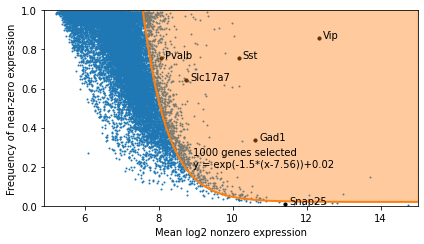

In [4]:
# We choose n most variable genes based on an heuristic appoach employed by Dmitry et al. in "The art of using t-sne
# for single-cell transcriptomics"
amount_of_genes = 1000
markerGenes = ['Snap25', 'Gad1', 'Slc17a7', 'Pvalb', 'Sst', 'Vip']
selectedGenes = sparseRRR.geneSelection(rpkm.T.values.astype(np.float), n=amount_of_genes, threshold=30, \
                                          markers=markerGenes, genes=np.array(list(rpkm.index)))
rpkm = rpkm.loc[selectedGenes]
print('RPKM shape:', rpkm.shape)
print('Ephys shape:', M1_ephys.shape)

In [5]:
rpkm.to_csv('data/scala_2020/gene_counts.csv')
M1_ephys.to_csv('data/scala_2020/ephys_values.csv')

Second part consists of preparing the data even further: normalizing and saving in a certain structure.

In [6]:
M1_ephys = pd.read_csv('data/scala_2020/ephys_values.csv', index_col=0)
rpkm = pd.read_csv('data/scala_2020/gene_counts.csv', index_col='gene')
geneNames = np.array(list(rpkm.index))

In [7]:
# Now specify for all the cells left what the cell type is (according to transcriptomic mappings)
prop = pd.read_csv('data/scala_2020/mini-atlas-meta-data.csv', sep = '\t')
prop = prop.rename(columns = {'Sample': 'sample_id', 'Targeted layer': 'Layer'})
prop = prop[['Cell', 'RNA type', 'sample_id', 'Layer', 'Cre', 'RNA type top-3']]
sample_name = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) for g in prop['Cell']]
prop['sample name'] = sample_name
prop = prop.set_index('sample name')

prop = prop.reindex(M1_ephys.index) # There could be more cells with ephys than manually labelled
                                    # They will receive the Nan property
prop = prop.fillna('')
M1_Mapping = prop['RNA type']
M1_Mapping[np.where(M1_Mapping == '')[0]] = 'low quality'
number_labels = {c: i for i, c in enumerate(np.unique(M1_Mapping))}
cellTypes = np.array([number_labels[cell_type] for cell_type in M1_Mapping])

In [8]:
print('Double check:\n')
print('RPKM shape: ', rpkm.shape)
print('ephys shape: ', M1_ephys.shape)
print('cellTypes shape: ', cellTypes.shape)

Double check:

RPKM shape:  (1000, 1213)
ephys shape:  (1213, 16)
cellTypes shape:  (1213,)


In [9]:
cellTypeColors = {'Lamp5 Pax6': '#DDACC9', 'Lamp5 Egln3_1': '#FF88AD', 'Lamp5 Egln3_2': '#DD8091', 'Lamp5 Egln3_3': '#F08E98',
 'Lamp5 Pdlim5_1': '#FF7290', 'Lamp5 Pdlim5_2': '#FF8C97', 'Lamp5 Slc35d3': '#FFA388', 'Lamp5 Lhx6': '#C77963',
 'Sncg Col14a1': '#7E0ACB', 'Sncg Slc17a8': '#9440F3', 'Sncg Calb1_1': '#9611B6', 'Sncg Calb1_2': '#9900B3',
 'Sncg Npy2r': '#7A0099', 'Vip Sncg': '#AA4DB5', 'Vip Serpinf1_1': '#A720FF', 'Vip Serpinf1_2': '#AB1DFF',
 'Vip Serpinf1_3': '#FF5FCD', 'Vip Htr1f': '#FF4DC1', 'Vip Gpc3': '#B09FFF', 'Vip C1ql1': '#BD3D9A',
 'Vip Mybpc1_1': '#F70CF3', 'Vip Mybpc1_2': '#992E81', 'Vip Mybpc1_3': '#AB379C', 'Vip Chat_1': '#FF00FF',
 'Vip Chat_2': '#B3128A', 'Vip Igfbp6_1': '#7779BF', 'Vip Igfbp6_2': '#626EB8', 'Sst Chodl': '#FFFF00',
 'Sst Penk': '#FF8011', 'Sst Myh8_1': '#FF9F2C', 'Sst Myh8_2': '#FFB307', 'Sst Myh8_3': '#FFBF09',
 'Sst Htr1a': '#BFAF00', 'Sst Etv1': '#FFB22B', 'Sst Pvalb Etv1': '#D9C566', 'Sst Crhr2_1': '#BE8652',
 'Sst Crhr2_2': '#B0993C', 'Sst Hpse': '#CDB115', 'Sst Calb2': '#D2A328', 'Sst Pvalb Calb2': '#784F14',
 'Sst Pappa': '#635821', 'Sst C1ql3_1': '#802600', 'Sst C1ql3_2': '#8A2B1A', 'Sst Tac2': '#804600',
 'Sst Th_1': '#8C6012', 'Sst Th_2': '#A81111', 'Sst Th_3': '#9B211B', 'Pvalb Gabrg1': '#ED4C50',
 'Pvalb Egfem1': '#C05661', 'Pvalb Gpr149': '#E62A5D', 'Pvalb Kank4': '#BC4B11', 'Pvalb Calb1_1': '#B6411E',
 'Pvalb Calb1_2': '#BC2D71', 'Pvalb Reln': '#9C4165', 'Pvalb Il1rapl2': '#BC2C41', 'Pvalb Vipr2_1': '#FF197F',
 'Pvalb Vipr2_2': '#F4358B', 'L2/3 IT_1': '#00FF34', 'L2/3 IT_2': '#07D945', 'L2/3 IT_3': '#2EB934',
 'L4/5 IT_1': '#09CCC6', 'L4/5 IT_2': '#52B8AA', 'L5 IT_1': '#58D2C1', 'L5 IT_2': '#4A9F93', 'L5 IT_3': '#4EAC9C',
 'L5 IT_4': '#52B4B8', 'L6 IT_1': '#B2AD23', 'L6 IT_2': '#81791F', 'L6 IT Car3': '#5100FF', 'L5 PT_1': '#0D5D7E',
 'L5 PT_2': '#0B77A5', 'L5 PT_3': '#0B8AA5', 'L5 PT_4': '#0A75B1', 'L5/6 NP_1': '#48CB80', 'L5/6 NP_2': '#3C78BC',
 'L5/6 NP_3': '#47867A', 'L5/6 NP CT': '#1AAB99', 'L6 CT Gpr139': '#168577', 'L6 CT Cpa6': '#338C5E', 'L6 CT Grp': '#2FBCE5',
 'L6 CT Pou3f2': '#3E766C', 'L6 CT Kit_1': '#516B78', 'L6 CT Kit_2': '#557361', 'L6b Col6a1': '#69419D',
 'L6b Shisa6_1': '#46306A', 'L6b Shisa6_2': '#464576', 'L6b Ror1': '#7044AA', 'L6b Kcnip1': '#573D90'}

Normalize

In [10]:
# Preprocess subset of the data in a systematic manner (library normalization and Z-scoring)
geneNames = np.array(list(rpkm.index))
Y = M1_ephys.values
X = rpkm.values.astype(np.float).T
X = X / np.sum(X, axis=1, keepdims=True) * \
                np.median(np.sum(X, axis=1, keepdims=True))

# Log-transform
X = np.log2(X + 1)

# Sort out cells with nans in the transcriptomic data
ind_non_nan = ~np.isnan(np.sum(X, axis=1))
X = X[ind_non_nan, :]
Y = Y[ind_non_nan, :]
cellTypes = cellTypes[ind_non_nan]

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

# Standardize X
mu = np.mean(X, axis=0)
X = X - mu
sigma = np.std(X, axis=0)
X = X / sigma

X = X.astype('float32')
Y = Y.astype('float32')

Save

In [11]:
data={'X':X, 'Y':Y, 'gene_names':geneNames, 'celltypes':cellTypes, 'map':M1_Mapping, \
      'ephys_features':M1_ephys.columns, 'colors':cellTypeColors}
pickle.dump(data, open('data/scala_2020/scala2020.pickle', 'wb'))

# Loading Gouwens 2020 data

Gouwens data has been largely preprocessed already. Check https://github.com/AllenInstitute/coupledAE-patchseq/tree/cplAE-TE/refactor .

In [3]:
# copied the utils directory from coupledAE-patchseq-cplAE-TE in this directory
from data.gouwens_2020.dataset import load_bioarxiv_dataset,partitions, Datagen

In [4]:
D = load_bioarxiv_dataset('./data/gouwens_2020/')
XT = D['T_dat']
XE = D['E_pcipfx']
T_dim = XT.shape[1]
E_dim = XE.shape[1]

In [5]:
print('Dataset contains ', XT.shape[0], 'neurons. We have', E_dim, 'ephys features and', T_dim, 'different genes.')

Dataset contains  3411 neurons. We have 68 ephys features and 1252 different genes.


Dataset already normalized but we're deleting cells with Nan ephys and keep only certain electrophysiological features that behave well (one cell was a consistent outlier and some ephys features are already too correlated with other ones).

In [15]:
Y = XE.copy()
X = XT.copy()

# Sort out cells with nans in the ephys data
ind_non_nan = ~np.isnan(np.sum(Y, axis=1))
X = X[ind_non_nan, :]
Y = Y[ind_non_nan, :]
cellTypes = D['cluster_id']
cellTypes = cellTypes[ind_non_nan]

X = X.astype('float32')
Y = Y.astype('float32')

In [16]:
features_to_drop=['spc0 spk. fast trough v',
 'long sq. stim. amp.',
 'spc1 step subthr.',
 'spc1 subthr. norm',
 'long sq. AP1 up-down ratio',
 'long sq. AP1 peak v',
 'long sq. AP1 threshold v',
 'long sq. AP1 width',
 'short sq. AP1 width',
 'spc1 inst. freq.',
 'spc3 inst. freq.',
 'long sq. AP1 downstroke',
 'spc2 inst. freq.']

In [17]:
features_to_drop_indices=[]
for el in features_to_drop:
    features_to_drop_indices.append(np.where(D['pcipfx_names']==el)[0][0])
features_to_drop_indices

[30, 67, 15, 17, 62, 59, 58, 63, 49, 21, 23, 61, 22]

We do, however, Z-score the ephys and gene data, especially because we want to do sRRR (sparse reduced-rank regression) and meaningfully compare to it with our sBNN.

In [18]:
Y = np.delete(Y,features_to_drop_indices,axis=1)
Y = Y-np.mean(Y,axis=0)
Y = Y/np.std(Y,axis=0)
X = X-np.mean(X,axis=0)
X = X/np.std(X,axis=0)

In [19]:
print('After kicking out Nan ephys neurons the dataset contains ', X.shape[0], \
      'neurons. We have', Y.shape[1], 'ephys features and', T_dim, 'different genes.')

After kicking out Nan ephys neurons the dataset contains  3395 neurons. We have 55 ephys features and 1252 different genes.


In [20]:
Gouwens_Mapping={}
for i in range(D['sample_id'][ind_non_nan].shape[0]):
    Gouwens_Mapping.update({D['sample_id'][ind_non_nan][i]:D['cluster'][ind_non_nan][i]})
Gouwens_Colors={}
for i in range(D['sample_id'][ind_non_nan].shape[0]):
    Gouwens_Colors.update({D['sample_id'][ind_non_nan][i]:D['cluster_color'][ind_non_nan][i]})

In [21]:
data={'X':X, 'Y':Y, 'gene_names':D['gene_id'], 'celltypes':D['cluster_id'][ind_non_nan], 'map':Gouwens_Mapping, \
      'ephys_features': np.delete(D['pcipfx_names'], features_to_drop_indices), 'colors':Gouwens_Colors}
pickle.dump(data, open('data/gouwens_2020/gouwens2020.pickle', 'wb'))

In [22]:
print('Double check:\n')
print('genes shape: ', data['X'].shape)
print('ephys shape: ', data['Y'].shape)
print('cellTypes shape: ', data['celltypes'].shape)

Double check:

genes shape:  (3395, 1252)
ephys shape:  (3395, 55)
cellTypes shape:  (3395,)


# Loading Stoeckius 2017 data

In [2]:
meta_data=pd.read_csv('./data/stoeckius_2017/CBMC_clustering.csv')
meta_data=meta_data.rename({'cell_barcode': 'bar_id'}, axis=1)
meta_data=meta_data.set_index('bar_id')
meta_data.fillna('NaN', inplace=True)
# Kick out cells that received no majour cord blood cell type or are not immune cells (yet)
keep=(meta_data.loc[:,'type']!='NaN') & (meta_data.loc[:,'type']!='Ery') 
meta_data=meta_data.loc[keep,:]
meta_data.head()

,tsne1,tsne2,cluster,type
bar_id,,,,
ATCATGGAGTAGGCCA,48.058009,16.400889,14,CD16 mono
TGACTAGAGGATCGCA,5.954810,28.816653,5,NK
GACCAATAGGGTATCG,-49.564798,7.253713,6,Pre
CTTAACTGTGGCGAAT,49.557221,15.614583,14,CD16 mono
TGCTACCAGTCATCCA,-49.605822,7.347255,6,Pre


First we deduce the colours the researcher used for their original tSNE map.

In [3]:
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt

def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [4]:
image=get_image('./data/stoeckius_2017/original_tsne.JPG')
modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

In [5]:
number_of_colors=13
clf = KMeans(n_clusters = number_of_colors)
labels = clf.fit_predict(modified_image)

[array([254.14177141, 254.33976642, 253.62459143]),
 array([206.10646833, 108.67156945,  58.98228314]),
 array([173.37997699, 207.03605677, 189.01806674]),
 array([246.88341589, 235.89018349,  77.73641247]),
 array([73.33169643, 69.06294643, 87.74151786]),
 array([246.44821298, 233.68234865, 164.64514953]),
 array([108.78573434, 171.39511373, 221.34358326]),
 array([194.05483959,  45.46558815,  51.3243762 ]),
 array([205.21715104, 151.3763815 , 135.04707327]),
 array([224.44540596, 231.37193518, 222.18647663]),
 array([117.04816223, 151.5887199 , 111.83618504]),
 array([195.9266481 ,  25.26508821, 135.83797586]),
 array([16.0283091 , 17.56771232, 15.65110941])]

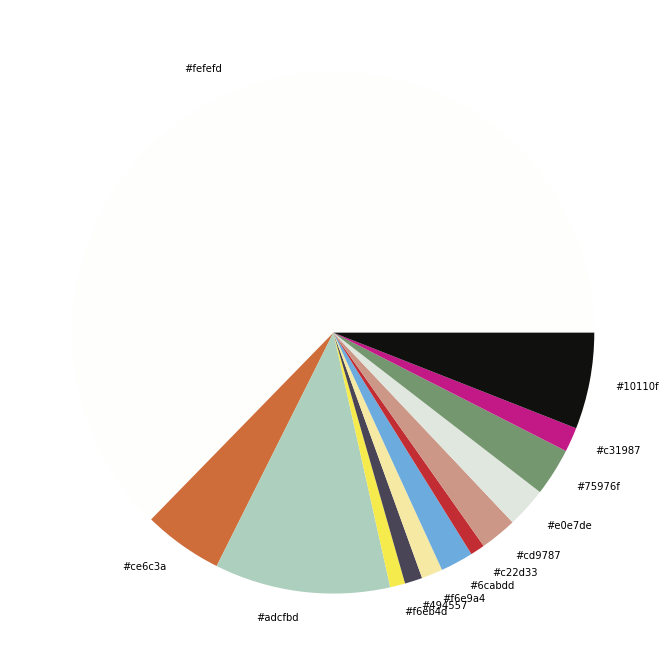

In [6]:
counts = Counter(labels)
show_chart=True

center_colors = clf.cluster_centers_
# We get ordered colors by iterating through the keys
ordered_colors = [center_colors[i] for i in counts.keys()]
hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
rgb_colors = [ordered_colors[i] for i in counts.keys()]

if (show_chart):
    plt.figure(figsize = (15, 12))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

rgb_colors

In [7]:
Stoeckius_mapping={'B': '#c31987', 'CD14 mono': '#f6eb4d',
                   'CD16 mono': '#75976f', 'CD4 T': '#adcfbd',
                   'CD8 T': '#c22d33', 'DC': '#ce6c3a',
                   'Ery': '#494557', 'NK': '#6cabdd',
                   'Pre':'#cd9686'}
#'NaN': '#10110f' 

In [8]:
rna=pd.read_csv('./data/stoeckius_2017/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv', skiprows=range(20401,37000))
rna=rna.rename({'Unnamed: 0': 'bar_id'}, axis=1)
rna=rna.set_index('bar_id').T
rna=rna.reindex(meta_data.index)
rna=rna.drop(['ERCC_ERCC-00104'], axis=1)
rna.columns=[c[6:] for c in rna.columns]
rna.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,...,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-125a,hsa-mir-335,hsa-mir-4259,hsa-mir-490,hsa-mir-5195,hsa-mir-6080,hsa-mir-7515
bar_id,,,,,,,,,,,,,,,,,,,,,
ATCATGGAGTAGGCCA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TGACTAGAGGATCGCA,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GACCAATAGGGTATCG,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CTTAACTGTGGCGAAT,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
TGCTACCAGTCATCCA,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Chosen offset: 0.08


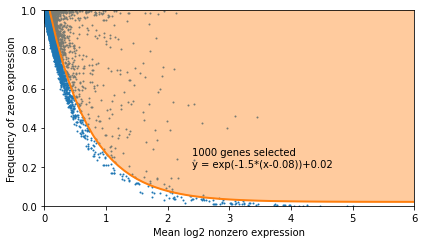

In [9]:
# Selecting 1000 most variable genes
amount_of_genes = 1000
selectedGenes = sparseRRR.geneSelection(rna.values.astype(np.float), n=amount_of_genes)
rna = rna.loc[:,selectedGenes]

In [10]:
adt=pd.read_csv('./data/stoeckius_2017/GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv')
adt=adt.rename({'Unnamed: 0': 'bar_id'}, axis=1)
adt=adt.set_index(['bar_id']).T
adt=adt.reindex(meta_data.index)
adt=adt.astype('float32')
adt.head()

bar_id,CD3,CD4,CD8,CD45RA,CD56,CD16,CD10,CD11c,CD14,CD19,CD34,CCR5,CCR7
bar_id,,,,,,,,,,,,,
ATCATGGAGTAGGCCA,370.0,1706.0,9559.0,102390.0,1518.0,4617.0,363.0,8204.0,4402.0,988.0,422.0,879.0,239.0
TGACTAGAGGATCGCA,1172.0,1528.0,1353.0,83685.0,1050.0,1950.0,252.0,2715.0,2429.0,790.0,220.0,472.0,189.0
GACCAATAGGGTATCG,1134.0,994.0,35.0,2123.0,22.0,32.0,50.0,25.0,284.0,30.0,129.0,34.0,46.0
CTTAACTGTGGCGAAT,41.0,160.0,2168.0,36504.0,552.0,1227.0,106.0,856.0,219.0,332.0,54.0,237.0,58.0
TGCTACCAGTCATCCA,203.0,20.0,1457.0,4871.0,24.0,25.0,36.0,12.0,37.0,53.0,83.0,28.0,40.0


Further preprocessing (Library normalization, log-transformation and Z-scoring):

In [11]:
X=rna.copy().values
X=np.log2(1 + X / np.sum(X, axis=1, keepdims=True) * np.median(np.sum(X, axis=1, keepdims=True)))
X_mean=X.mean(axis=0)
X_std=X.std(axis=0)
X-=X_mean
X/=X_std

Y=adt.copy().values
Y_mean=Y.mean(axis=0)
Y_std=Y.std(axis=0)
Y-=Y_mean
Y/=Y_std

X = X.astype('float32')
Y = Y.astype('float32')

In [12]:
data={'X':X, 'Y':Y, 'gene_names':np.array(rna.columns), \
      'adt_features': np.array(adt.columns), 'celltypes':meta_data.loc[:,'type'].values, \
      'map': Stoeckius_mapping}
pickle.dump(data, open('data/stoeckius_2017/stoeckius_2017.pickle', 'wb'))

In [13]:
print('Double check:\n')
print('rna shape: ', data['X'].shape)
print('dta shape: ', data['Y'].shape)
print('celltype shape: ', data['celltypes'].shape)

Double check:

rna shape:  (7652, 1000)
dta shape:  (7652, 13)
celltype shape:  (7652,)


## tSNE ephys and genes for Scala et al. 2020

In [37]:
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [40]:
def PCA_sklearn(data):
    '''
    Function that performs PCA on the input data, using sklearn
    
    input: (cells,genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes)-shaped array containing the principal components as columns
    ''' 
    pca = PCA(svd_solver='full').fit(data)
    data_transformed = pca.transform(data)    
    principal_components = pca.components_.T
    fraction_variance_explained = pca.explained_variance_ratio_
    
    return fraction_variance_explained, principal_components

def select_PCs(variance_explained,principal_components,percent_variance=None):
    '''Function that selects the first n principal components necessary to explain x% of the variance
    input: 
        variance_explained: amount of variance explained by the individual PCs
        principal_components: contains the principal components as columns
        percent_variance: fraction of the variance, the all PCs that are kept explain
    output:
        variance_explained_kept: individual amount of variance explained for the remaining PCs
        principal_components_kept: remaining principal components, shape (genes,n_PCs_kept)
                
    '''
    total_variance_explained = np.cumsum(variance_explained)
    n_PCs_kept = sum(total_variance_explained<percent_variance) + 1    
    variance_explained_kept = variance_explained[:n_PCs_kept]
    principal_components_kept = principal_components[:,:n_PCs_kept]
            
    return variance_explained_kept,principal_components_kept

def compute_PCA_scores(data,principal_components):
    '''Function that returns the PC scores for each data point
    input: 
        data                 --- (cells,genes)-shaped array of log transformed cell counts
        principal_components --- contains the principal components as columns\
    output:
        pc_scores            --- (cells,n_PCs_kept)-shaped array of PC scores
    
    ''' 
    pc_scores = np.array(data @ principal_components)

    return pc_scores

In [35]:
scala = pickle.load(open('data/scala_2020/scala2020.pickle', 'rb'))

In [41]:
#do sklearn-PCA on selected genes
var_expl, PCs = PCA_sklearn(scala['X'])

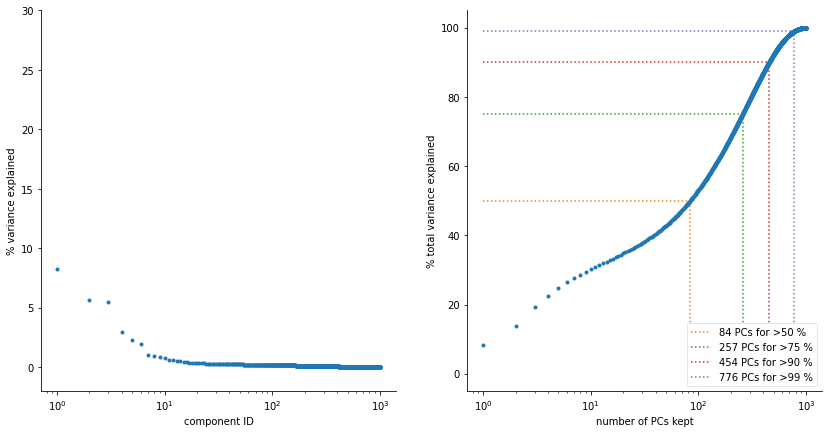

In [42]:
n_PCs = len(var_expl)
PC_ids = np.arange(1,n_PCs+1)

plt.figure(figsize=(14,7))

plt.subplot(121)
plt.plot(PC_ids,100*var_expl,'.')
plt.xlabel('component ID')
plt.ylabel('% variance explained')
plt.xscale('log')
plt.ylim(-2,30)


plt.subplot(122)
total_variance_explained = np.cumsum(100*var_expl)
plt.plot(PC_ids,total_variance_explained,'.')
plt.xlabel('number of PCs kept')
plt.ylabel('% total variance explained')
for variance_level,c in zip([50,75,90,99],['tab:orange','tab:green','tab:red','tab:purple']):
    n_PCs_needed = sum(total_variance_explained<variance_level) + 1
    legend_string = '%u PCs for >%u %%' % (n_PCs_needed,variance_level)
    plt.hlines(variance_level,1,n_PCs_needed,label=legend_string,colors=c,linestyles=':')
    plt.vlines(n_PCs_needed,0,variance_level,colors=c,linestyles=':')
leg = plt.legend(loc=4)
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_alpha(1)
plt.xscale('log')
sns.despine()

In [45]:
#do sklearn-PCA on selected genes
var_expl, PCs = PCA_sklearn(scala['X'])
#select components as before
_, PCs_40 = select_PCs(var_expl, PCs, 0.4)
#get PC scores
PCA_40 = compute_PCA_scores(scala['X'], PCs_40)

In [63]:
Z_genes = TSNE(perplexity=30, method='exact', random_state=42).fit_transform(PCA_40)
Z_ephys = TSNE(perplexity=30, method='exact', random_state=42).fit_transform(scala['Y'])

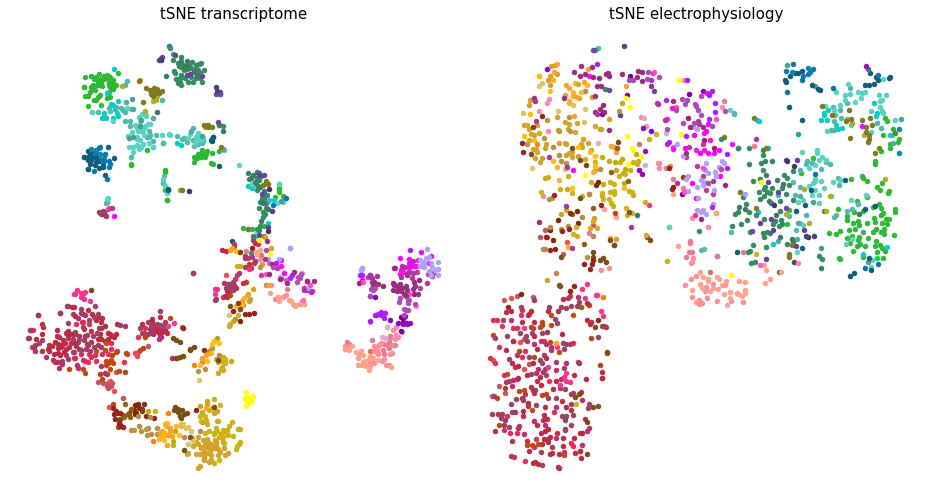

In [69]:
fig, axes = plt.subplots(1,2,figsize=(13,7))
for celltype in np.unique(scala['map']):
    indices=scala['map']==celltype
    axes[0].scatter(Z_genes[indices,0], Z_genes[indices,1], c=scala['colors'][celltype],
            s=20)#, label=celltype)
    axes[1].scatter(Z_ephys[indices,0], Z_ephys[indices,1], c=scala['colors'][celltype],
            s=20)#, label=celltype)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_title('tSNE transcriptome', fontsize=15)
axes[1].set_title('tSNE electrophysiology', fontsize=15)
sns.despine(bottom=True, left=True)
plt.tight_layout()
plt.savefig('./figures/preliminary/scala_tsne.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('./figures/preliminary/scala_tsne.pdf', bbox_inches = 'tight',
     pad_inches = 0)